In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score

In [233]:
import xgboost
from xgboost import XGBClassifier

In [234]:
train=pd.read_csv("./RefinedData/Training_dataset_Original.csv", low_memory=False)
test=pd.read_csv("./RefinedData/Leaderboard_dataset.csv", low_memory=False)
train.drop(columns = ['mvar4', 'mvar5'])
test.drop(columns = ['mvar4', 'mvar5'])
train.drop(columns = ['mvar17', 'mvar19'])
test.drop(columns = ['mvar17', 'mvar19'])

,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,...,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,350053,1753,0.5001,0.000,0.0000,0.000,206,19179,206,14221,...,1,0,missing,20.551,0.42105,3,0.85661,na,0,L
1,350054,1894,1.9701,0.000,0.0000,0.000,297,19820,19820,176895,...,3,0,missing,63.047,0,15,0.94391,0,0,C
2,350055,1774,0.1718,0.000,0.0000,0.000,197,2563,877,8869,...,1,0,missing,83.797,0.33333,3,0.76467,0,0,C
3,350056,1586,0.1123,5.299,0.0000,0.000,missing,missing,missing,missing,...,1,na,missing,missing,1.5,0,NaN,na,na,C
4,350057,1832,1.4442,0.000,0.0000,0.000,179,7577,179,21059,...,3,0,96.052,66.665,0,23,0.79190,0,0,L
5,350058,1838,0.0544,0.241,0.0000,0.000,882,14039,10976,278941,...,4,0,missing,77.78,0,21,0.92462,0,0,L
6,350059,1743,1.0753,0.272,0.0000,0.000,397,16141,3568,69482,...,6,0,missing,67.159,0,14,0.71347,0,0,L
7,350060,1935,0.5601,0.000,0.0000,0.000,496,44919,17115,124814,...,9,0,missing,missing,0,15,0.92403,0,0,L
8,350061,1885,0.0811,0.000,0.0000,0.000,7369,19264,19264,59956,...,1,0,missing,missing,0,5,0.89760,0,na,L
9,350062,1730,0.7444,0.000,0.0000,0.000,0,2103,582,16429,...,9,0,missing,missing,0.05882,14,0.40529,na,0,C


In [235]:
def replace_nan(data):
    data = data.replace("nan", np.nan)
    data = data.replace("missing", np.nan)
    data = data.replace("na", np.nan)
    return data

In [236]:
train = replace_nan(train)
test = replace_nan(test)

In [237]:
def fill_data(data):
    data['mvar47'] = data['mvar47'] == 'C'
    data = data.astype(dtype='float64')
    data = data.fillna(data.median())
#     data = data.fillna(data.mean())
    return data

In [238]:
train = fill_data(train)
test = fill_data(test)

In [239]:
data=pd.concat([train, test], sort=False)
# data=pd.concat([train.drop('default_ind', axis=1), test])

In [240]:
test.head()

,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,...,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,350053.0,1753.0,0.5001,0.000,0.0,0.0,206.0,19179.0,206.0,14221.0,...,1.0,0.0,100.000,20.551,0.42105,3.0,0.85661,0.0,0.0,0.0
1,350054.0,1894.0,1.9701,0.000,0.0,0.0,297.0,19820.0,19820.0,176895.0,...,3.0,0.0,100.000,63.047,0.00000,15.0,0.94391,0.0,0.0,1.0
2,350055.0,1774.0,0.1718,0.000,0.0,0.0,197.0,2563.0,877.0,8869.0,...,1.0,0.0,100.000,83.797,0.33333,3.0,0.76467,0.0,0.0,1.0
3,350056.0,1586.0,0.1123,5.299,0.0,0.0,297.0,7011.5,2503.0,14072.0,...,1.0,0.0,100.000,79.123,1.50000,0.0,0.73274,0.0,0.0,1.0
4,350057.0,1832.0,1.4442,0.000,0.0,0.0,179.0,7577.0,179.0,21059.0,...,3.0,0.0,96.052,66.665,0.00000,23.0,0.79190,0.0,0.0,0.0


In [241]:
def preparing_data(train,test):

    categorical = ["mvar16", "mvar34"]

    def replacing_categorical(X):
        x=train.groupby(X)["default_ind"].mean()
        y=train.groupby(X)["default_ind"].std()
#         data[X+str("_mean")]= data[X].apply(lambda X1: x[X1])
#         data[X+str("_std")] = data[X].apply(lambda X2: y[X2])

    for i in categorical:
        replacing_categorical(i)
   
    train_new = data.iloc[0:train.shape[0]]
    test_new = data.iloc[train.shape[0]:data.shape[0]]

    def prepare_data(df, is_train):
        # Dropping cm_key
#         df = df.drop(["application_id"], axis=1)
        # Dropping mvar1 due to uniformity
#         df  = df.drop(["mvar1"], axis=1)
        if is_train:
            return df.drop(['application_key',"default_ind"], axis=1), df['default_ind']
        return df.drop(['application_key',"default_ind"], axis=1)


    train_features, train_target = prepare_data(train_new, 1)
    test_features = prepare_data(test_new, 0)
    
    return train_features, train_target, test_features

In [242]:
train_features, train_target, test_features = preparing_data(train,test)

In [243]:
test_features.head()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,...,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,1753.0,0.5001,0.000,0.0,0.0,206.0,19179.0,206.0,14221.0,19438.0,...,1.0,0.0,100.000,20.551,0.42105,3.0,0.85661,0.0,0.0,0.0
1,1894.0,1.9701,0.000,0.0,0.0,297.0,19820.0,19820.0,176895.0,66346.0,...,3.0,0.0,100.000,63.047,0.00000,15.0,0.94391,0.0,0.0,1.0
2,1774.0,0.1718,0.000,0.0,0.0,197.0,2563.0,877.0,8869.0,3637.0,...,1.0,0.0,100.000,83.797,0.33333,3.0,0.76467,0.0,0.0,1.0
3,1586.0,0.1123,5.299,0.0,0.0,297.0,7011.5,2503.0,14072.0,0.0,...,1.0,0.0,100.000,79.123,1.50000,0.0,0.73274,0.0,0.0,1.0
4,1832.0,1.4442,0.000,0.0,0.0,179.0,7577.0,179.0,21059.0,20306.0,...,3.0,0.0,96.052,66.665,0.00000,23.0,0.79190,0.0,0.0,0.0


In [244]:
def model(train,test):
    train_features, train_target, test_features = preparing_data(train,test)
    Xtrain, Xtest, ytrain, ytest = train_test_split( train_features, train_target,
                                                    stratify=train_target, test_size=.3, random_state=100)
    
    print(train_features.head())
#     train_features = train_features.values
#     test_features = test_features.values
    xgb = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
    xgb.fit(train_features, train_target)
    
    print ("Training :"+str(accuracy_score( ytrain, xgb.predict(Xtrain))))
    print ("Test :"+str(accuracy_score( ytest, xgb.predict(Xtest))))
    print ("ROC_AUC :"+str(roc_auc_score( ytest, xgb.predict(Xtest))))
    print ("precision_score :"+str(precision_score( ytest, xgb.predict(Xtest))))
    print ("recall_score :"+str(recall_score( ytest, xgb.predict(Xtest))))
    print ("confusion_matrix :"+ str(confusion_matrix(ytest, xgb.predict(Xtest))))

    def myscorer(cm):
        False1 = cm[0][1]
        False2 = cm[1][0]
        return (3*False1) + (False2), (False1+False2)

    print ("myscorer :"+ str(myscorer(confusion_matrix(ytest, xgb.predict(Xtest)))))
           
    ax = xgboost.plot_importance(xgb)
    fig = ax.figure
    fig.set_size_inches(15, 15)

In [245]:
# train = train.astype(dtype='float64')
# test = test.astype(dtype='float64')

    mvar1   mvar2  mvar3  mvar4  mvar5   mvar6    mvar7   mvar8    mvar9  \
0  1696.0  1.6541  0.000    0.0    0.0     0.0   6015.0   322.0  40369.0   
1  1846.0  0.8095  0.000    0.0    0.0   102.0   7532.0  3171.0  18234.0   
2  1745.0  0.4001  0.000    0.0    0.0   297.0   2536.0  2478.0  14171.0   
3  1739.0  0.2193  0.000    0.0    0.0  1982.0  26440.0  4955.0  20316.0   
4  1787.0  0.0118  0.225    0.0    0.0  5451.0   5494.0  5494.0   7987.0   

    mvar10   ...    mvar38  mvar39   mvar40   mvar41   mvar42  mvar43  \
0  18414.0   ...       4.0     1.0   73.780  82.5470  0.08696    10.0   
1  13664.0   ...       2.0     0.0   99.129  78.8835  0.00000    13.0   
2   2536.0   ...       1.0     0.0  100.000  29.2900  0.00000     1.0   
3  37013.0   ...       2.0     0.0   96.272  78.8835  0.15385     3.0   
4   4696.0   ...       2.0     0.0  115.019  78.8835  0.00000     1.0   

    mvar44  mvar45  mvar46  mvar47  
0  0.63899     0.0     0.0     1.0  
1  0.63836     0.0     0.0    

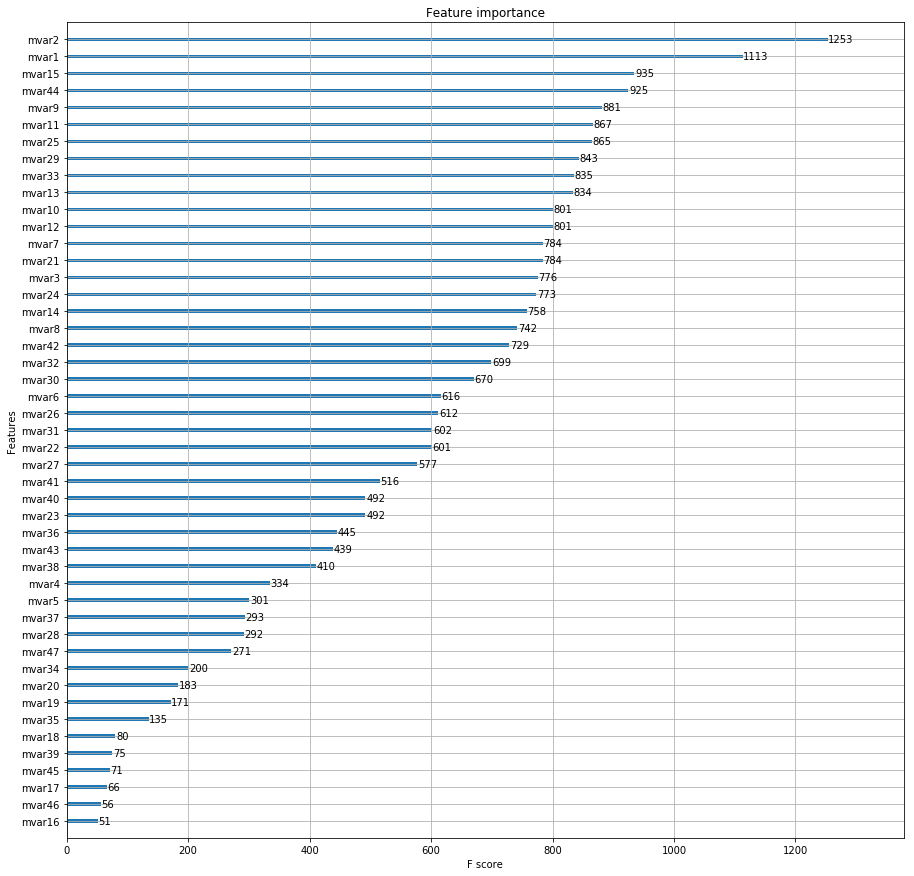

In [246]:
model(train, test)

In [247]:
train_features, train_target, test_features = preparing_data(train, test)
xgb = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb.fit(train_features, train_target)
submission = pd.concat([test["application_key"], pd.DataFrame(xgb.predict_proba(test_features), columns=["0","1"])], axis=1)

In [248]:
# xgb.predict_proba(test_features)
test_features.shape

(25000, 47)

In [249]:
submission_pred = xgb.predict(test_features)

In [250]:
submission_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [251]:
submission.head()

,application_key,0,1
0,350053.0,0.961871,0.038129
1,350054.0,0.854476,0.145524
2,350055.0,0.880983,0.119017
3,350056.0,0.321437,0.678563
4,350057.0,0.900587,0.099413


In [22]:
# Y_pred=xgb1.predict(X_test)

In [23]:
# xgb1.predict_proba(X_test)

In [24]:
# float(np.sum(Y_pred == Y_test))/float(np.sum(Y_test == Y_test))

In [25]:
# metrics.accuracy_score(Y_test, Y_pred)

In [26]:
# X_lead = pd.read_csv('./RefinedData/refined_leaderboard_data.csv', low_memory=False)

In [27]:
# X_lead.head()

In [28]:
# Y_lead=pd.DataFrame(xgb1.predict(X_lead))

In [29]:
# Y_prob = xgb1.predict_proba(X_lead)
# Y_prob

In [252]:
submission

,application_key,0,1
0,350053.0,0.961871,0.038129
1,350054.0,0.854476,0.145524
2,350055.0,0.880983,0.119017
3,350056.0,0.321437,0.678563
4,350057.0,0.900587,0.099413
5,350058.0,0.997440,0.002560
6,350059.0,0.928686,0.071314
7,350060.0,0.995994,0.004006
8,350061.0,0.996036,0.003964
9,350062.0,0.771090,0.228910


In [253]:
# Y_wt = Y_prob[:,0]
Y_wt = submission.values[:, 1]
#Y_wt = np.abs(Y_wt - 0.5)
Y_wt

array([0.96187085, 0.85447633, 0.88098347, ..., 0.87311167, 0.9487834 ,
       0.990951  ])

In [254]:
sol = pd.DataFrame()
sol['priority'] = pd.Series(Y_wt)
sol['application_key'] = submission['application_key'].astype(dtype='int')
sol['default_ind'] = submission_pred.astype(dtype='int')

In [255]:
sol.head()

,priority,application_key,default_ind
0,0.961871,350053,0
1,0.854476,350054,0
2,0.880983,350055,0
3,0.321437,350056,1
4,0.900587,350057,0


In [256]:
sol = sol.sort_values(by = 'priority', ascending = False)
sol.head()

,priority,application_key,default_ind
124,0.999767,350177,0
49,0.999727,350102,0
22865,0.999717,372918,0
22292,0.999714,372345,0
21270,0.999705,371323,0


In [257]:
sol = sol.drop('priority', axis = 1)
sol.to_csv('./Submissions/Analyzing_IITGuwahati_53.csv', index = False, header=False)